<a href="https://colab.research.google.com/github/chloeli-15/elhage2022-replication/blob/main/ToyModelsofSuperposition_BasicResults_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication of [Elhage (2022) - Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html)

## Installation

In [ ]:
%pip install einops
%pip install jaxtyping
%pip install torchinfo
%pip install wandb
%pip install transformer_lens
%pip install torchvision
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 928.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import os
import einops
from einops import rearrange
import fancy_einsum
import torch as t
from torch import nn
from dataclasses import dataclass
# import torchvision
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from tqdm import tqdm
from typing import List, Callable, Tuple
from jaxtyping import Float
from PIL import Image
import plotly.express as px
from IPython.display import display
import torchinfo
from torchinfo import summary
import json
import pandas as pd
from typing import Union, Optional
import functools
from fancy_einsum import einsum
import numpy as np
from tqdm import tqdm
import time
from plotly.subplots import make_subplots
from frozendict import frozendict
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Model Setup and Training

In [ ]:
class ReLU_Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W = nn.Parameter(t.empty((cfg.d_model, cfg.d_feature))) #shape: [d_model, d_feature], initialized with weights sampled from unit Gaussian
        nn.init.xavier_normal_(self.W) #Xavier normal initialization
        self.bias = nn.Parameter(t.zeros((cfg.d_feature)))
        self.ReLU = nn.ReLU()

    def forward(self, input):
        h = einsum('... d_feature, d_model d_feature -> ... d_model', input, self.W)
        out = self.ReLU(einsum('... d_model, d_model d_feature -> ... d_feature', h, self.W) + self.bias)
        return out

class Linear_Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W = nn.Parameter(t.empty((cfg.d_model, cfg.d_feature))) #shape: [d_model, d_feature], initialized with weights sampled from unit Gaussian
        nn.init.xavier_normal_(self.W) #Xavier normal initialization
        self.bias = nn.Parameter(t.zeros((cfg.d_feature)))

    def forward(self, input):
        h = einsum("... d_feature, d_model d_feature -> ... d_model", input, self.W)
        out = einsum("... d_model, d_model d_feature -> ... d_feature", h, self.W) + self.bias
        return out

def MSE_loss(output: Float[t.Tensor, "batch d_feature"], input: Float[t.Tensor, "batch d_feature"], importance: Float[t.Tensor, "batch d_feature"]):
    error=importance * ((input-output)**2)
    return t.sum(error)


In [ ]:
class Config:
    d_model: int = 5
    d_feature: int = 20
    #debug: bool = True

class TrainingArgs():
    epoch: int = 5000
    batch_size: int = 1024
    device: str = "cuda" if t.cuda.is_available() else "cpu"
    optimizer_kwargs: dict = frozendict(lr=0.001, betas=(0.9, 0.999))
    lr: float = 1e-3


## Training
def train_model(model: ReLU_Model or Linear_Model, importance: float, sparsity: float, args: TrainingArgs) -> list:
    sparsity_vector = (t.rand(args.batch_size, cfg.d_feature) > sparsity).float()
    importance_vector = t.tensor([importance**i for i in range(cfg.d_feature)], dtype=t.float32) #importance = 0.9^i
    importance_vector = einops.repeat(importance_vector, "d_feature -> batch d_feature", batch = args.batch_size)

    optimizer = t.optim.AdamW(list(model.parameters()), lr=args.lr)

    model.to(args.device)
    train_loss_list = []

    for epoch in tqdm(range(args.epoch)):
          input_raw = t.rand(args.batch_size, cfg.d_feature)
          input = einops.einsum(input_raw, sparsity_vector, "batch d_feature, batch d_feature -> batch d_feature")
          output = model.forward(input)
          loss = MSE_loss(output, input, importance_vector)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          train_loss_list.append(loss.item())
          #runner.set_description(f"{loss.item()=}") #

    #t.save(model, f"ReLU_toyModel_{sparsity}.pth")

    if epoch%1000==0:
      print(optimizer.param_groups[0]['lr'])

    return train_loss_list


100%|██████████| 5000/5000 [00:08<00:00, 562.38it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

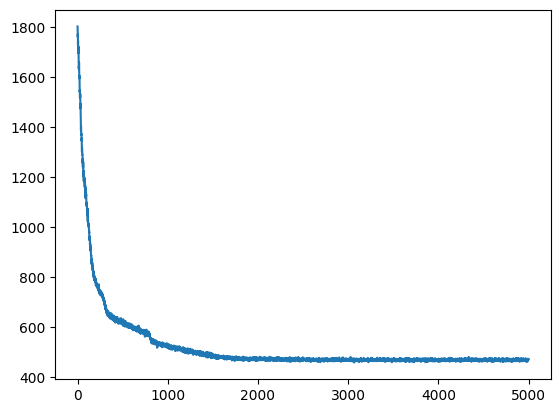

In [ ]:
cfg = Config()
args = TrainingArgs()

#different sparsity
model = ReLU_Model(cfg)
train_loss_list = train_model(model, 0.9, 0.1, args)

plt.plot(train_loss_list)
plt.show

### Visualizing

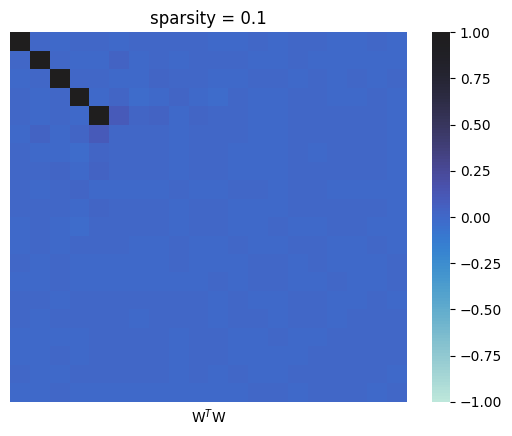

In [ ]:
import seaborn as sns

WW= einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model.W, model.W).detach().numpy() # This should be the identity matrix when sparsity is low

ax = sns.heatmap(WW, linewidth=0, center=1, vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
ax.set(xlabel="W$^T$W", title="sparsity = 0.1")
plt.show()

## Basic Results - Replication

### Visualizing superposition in ReLU models against input sparsity

100%|██████████| 5000/5000 [00:10<00:00, 494.73it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

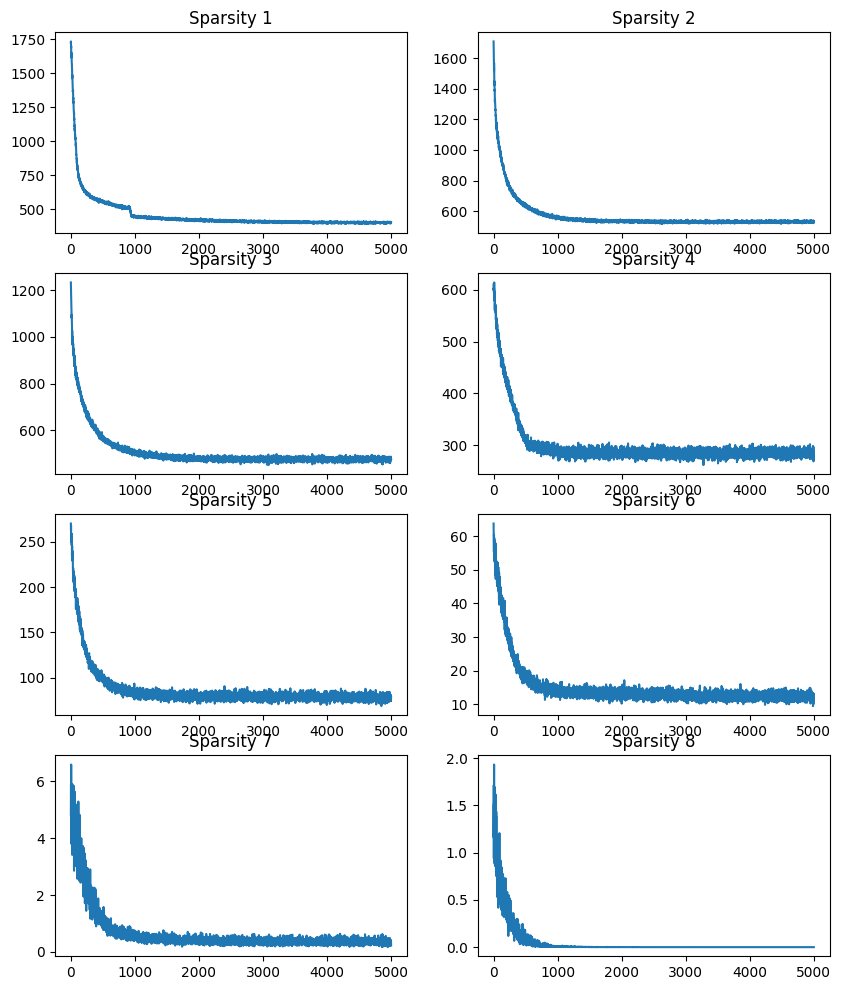

In [ ]:
#different sparsity
model_S0 = ReLU_Model(cfg)
model_S03 = ReLU_Model(cfg)
model_S05 = ReLU_Model(cfg)
model_S07 = ReLU_Model(cfg)
model_S09 = ReLU_Model(cfg)
model_S097 = ReLU_Model(cfg)
model_S0997 = ReLU_Model(cfg)
model_S0999 = ReLU_Model(cfg)


train_loss_list0 = train_model(model_S0, 0.9, 0.0, args)
train_loss_list03 = train_model(model_S03, 0.9, 0.3, args)
train_loss_list05 = train_model(model_S05, 0.9, 0.5, args)
train_loss_list07 = train_model(model_S07, 0.9, 0.7, args)
train_loss_list09 = train_model(model_S09, 0.9, 0.9, args)
train_loss_list097 = train_model(model_S097, 0.9, 0.97, args)
train_loss_list0997 = train_model(model_S0997, 0.9, 0.997, args)
train_loss_list0999 = train_model(model_S0999, 0.9, 0.999, args)

loss_list = [train_loss_list0, train_loss_list03, train_loss_list05, train_loss_list07, train_loss_list09, train_loss_list097, train_loss_list0997, train_loss_list0999]
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    ax.plot(loss_list[i])
    ax.set_title(f'Sparsity {i+1}')
plt.show



In [ ]:
t.save(model_S0, "ReLU_toyModel_sparsity0.pth")
t.save(model_S03, "ReLU_toyModel_sparsity03.pth")
t.save(model_S05, "ReLU_toyModel_sparsity05.pth")
t.save(model_S07, "ReLU_toyModel_sparsity07.pth")
t.save(model_S09, "ReLU_toyModel_sparsity09.pth")
t.save(model_S097, "ReLU_toyModel_sparsity097.pth")
t.save(model_S0997, "ReLU_toyModel_sparsity0997.pth")
t.save(model_S0999, "ReLU_toyModel_sparsity0999.pth")

We expect that

*   When input is not sparse (i.e. co-occur frequently), nonlinear ReLU models will not engage in superposition because representing features using non-othogonal dimensions will create high interference during readout $⇒$ model will learn W$^T$W that is an identity matrix for the important features and **zero** for the rest
*   When input is highly sparse, nonlinear models can represent more features than it has dimensions via superposition without interference $⇒$ model will learn W$^T$W that is not mostly zero and has a longer diagonal



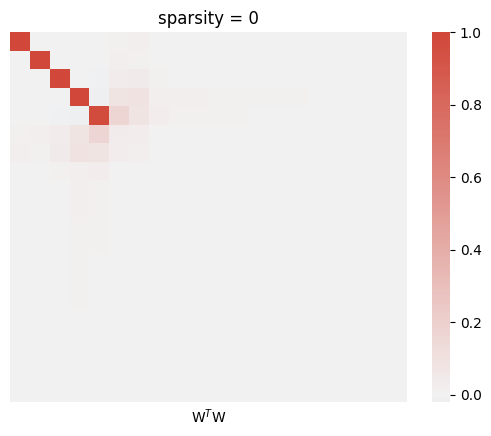

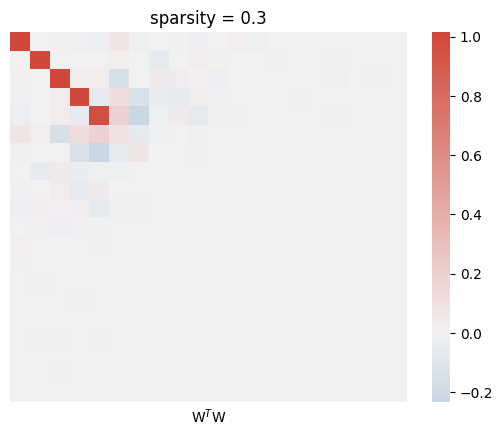

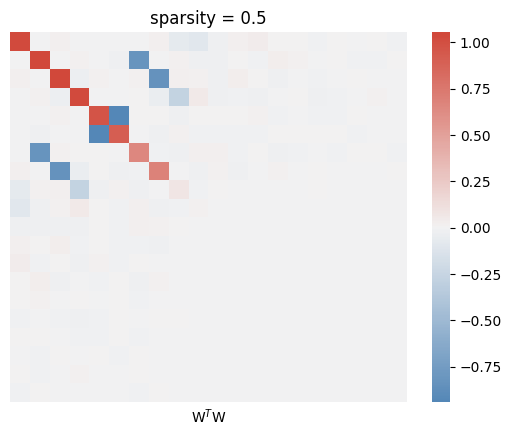

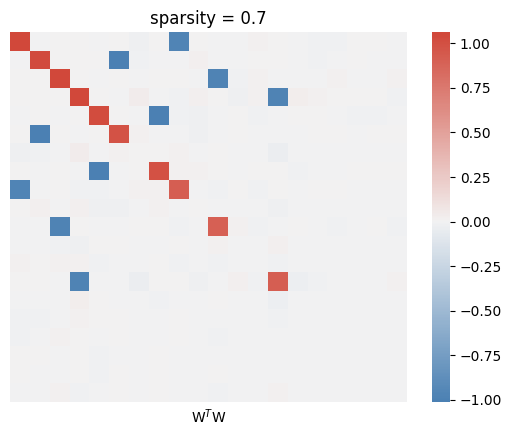

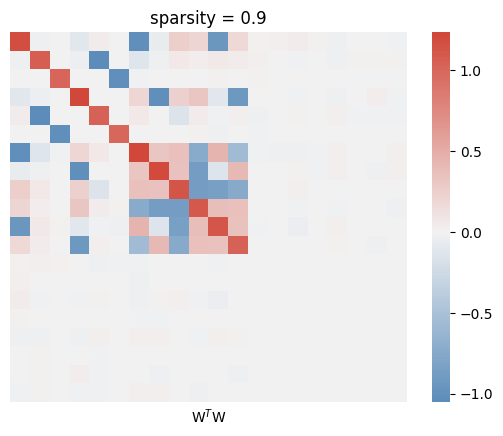

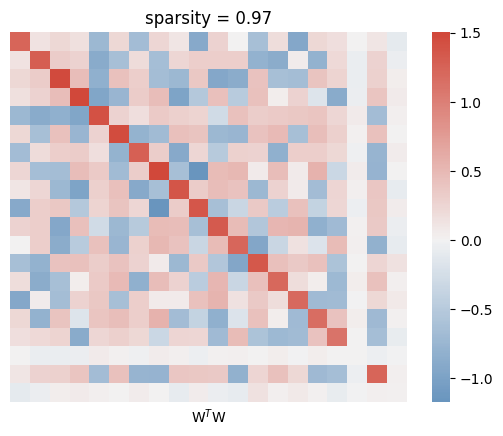

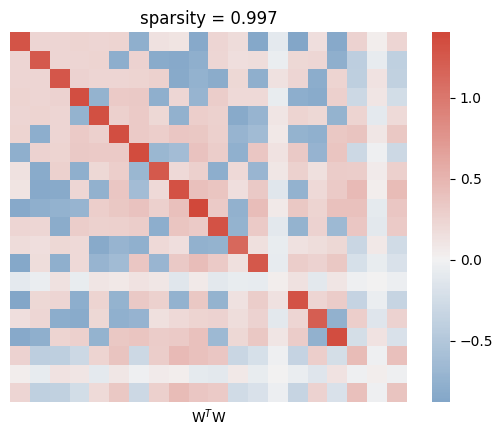

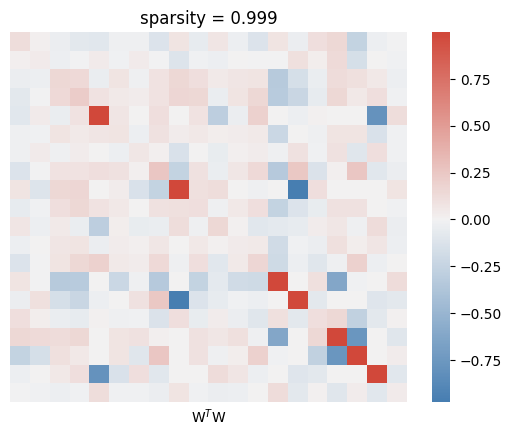

In [ ]:
WW1 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S0.W, model_S0.W).detach().numpy() # This should be the identity matrix when sparsity is low
WW2 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S03.W, model_S03.W).detach().numpy() # This should be the identity matrix when sparsity is low
WW3 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S05.W, model_S05.W).detach().numpy() # This should be the identity matrix when sparsity is low
WW4 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S07.W, model_S07.W).detach().numpy() # This should be the identity matrix when sparsity is low
WW5 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S09.W, model_S09.W).detach().numpy() # This should be the identity matrix when sparsity is low
WW6 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S097.W, model_S097.W).detach().numpy() # This should be the identity matrix when sparsity is low
WW7 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S0997.W, model_S0997.W).detach().numpy() # This should be the identity matrix when sparsity is low
WW8 = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", model_S0999.W, model_S0999.W).detach().numpy() # This should be the identity matrix when sparsity is low

WW = [WW1, WW2, WW3, WW4, WW5, WW6, WW7, WW8]
sparsity = [0, 0.3, 0.5, 0.7, 0.9, 0.97, 0.997, 0.999]
cmap = sns.diverging_palette(245, 15, as_cmap=True)

for i in range(8):
  ax = sns.heatmap(WW[i], linewidth=0, center=0, xticklabels=False, yticklabels=False, cmap = cmap)
  ax.set(xlabel="W$^T$W", title=f"sparsity = {sparsity[i]}")
  plt.show()


### Visualizing superposition in linear models

For linear models (with no ReLU), we should expect no superposition, even with very high sparsity. This is because without ReLU to

100%|██████████| 5000/5000 [00:09<00:00, 554.13it/s]


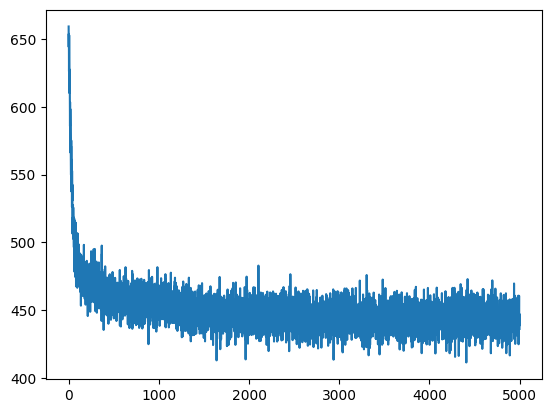

In [ ]:
linear_model = Linear_Model(cfg)
train_loss_list = train_model(linear_model, 1, 0.9, args)
plt.plot(train_loss_list)
plt.show()

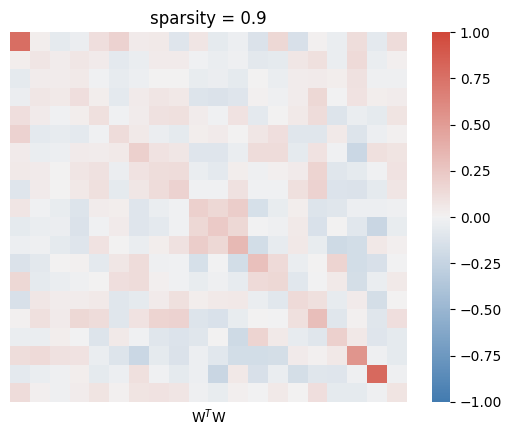

In [ ]:
WW_linear = einsum("d_model d_feature1, d_model d_feature2 -> d_feature1 d_feature2", linear_model.W, linear_model.W).detach().numpy()
ax = sns.heatmap(WW_linear, linewidth=0, vmax=1, vmin=-1, center=0, xticklabels=False, yticklabels=False, cmap = cmap)
ax.set(xlabel="W$^T$W", title=f"sparsity = 0.9")
plt.show()